<a href="https://colab.research.google.com/github/bdgToji/VNP/blob/main/KOL2_Sentiment_JobApp_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

In [3]:
! pip install transformers[torch] datasets evaluate

In [75]:
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import evaluate
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
df = pd.read_csv('/content/drive/MyDrive/VNP/fake_job_postings.csv')

In [6]:
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [7]:
df = df.drop(columns=['title','location','department','salary_range','company_profile','requirements','benefits','telecommuting','has_company_logo','has_questions','employment_type','required_experience','required_education','industry','function'])

In [8]:
df = df.drop(columns=['job_id'])

In [9]:
df

,description,fraudulent
0,"Food52, a fast-growing, James Beard Award-winn...",0
1,Organised - Focused - Vibrant - Awesome!Do you...,0
2,"Our client, located in Houston, is actively se...",0
3,THE COMPANY: ESRI – Environmental Systems Rese...,0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0
...,...,...
17875,Just in case this is the first time you’ve vis...,0
17876,The Payroll Accountant will focus primarily on...,0
17877,Experienced Project Cost Control Staff Enginee...,0
17878,Nemsia Studios is looking for an experienced v...,0


In [10]:
df['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

In [11]:
df.isna().sum()

description    1
fraudulent     0
dtype: int64

In [12]:
df = df.dropna(axis=0)

In [13]:
df.isna().sum()

description    0
fraudulent     0
dtype: int64

In [14]:
df[['description','label']] = df[['description','fraudulent']]

<ipython-input-14-93300e4500e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['description','label']] = df[['description','fraudulent']]
<ipython-input-14-93300e4500e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['description','label']] = df[['description','fraudulent']]


In [15]:
df = df.drop(columns=['fraudulent'])

In [16]:
df

,description,label
0,"Food52, a fast-growing, James Beard Award-winn...",0
1,Organised - Focused - Vibrant - Awesome!Do you...,0
2,"Our client, located in Houston, is actively se...",0
3,THE COMPANY: ESRI – Environmental Systems Rese...,0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0
...,...,...
17875,Just in case this is the first time you’ve vis...,0
17876,The Payroll Accountant will focus primarily on...,0
17877,Experienced Project Cost Control Staff Enginee...,0
17878,Nemsia Studios is looking for an experienced v...,0


In [17]:
df['label'].value_counts()

label
0    17014
1      865
Name: count, dtype: int64

In [18]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [19]:
df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

In [20]:
dataset = load_dataset('csv', data_files={'train':'df_train.csv', 'test':'df_test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['description', 'label'],
        num_rows: 14303
    })
    test: Dataset({
        features: ['description', 'label'],
        num_rows: 3576
    })
})

In [22]:
def tokenize_function(examples):
    return tokenizer(examples["description"], padding="max_length", truncation=True)

In [23]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/14303 [00:00<?, ? examples/s]

Map:   0%|          | 0/3576 [00:00<?, ? examples/s]

In [24]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    learning_rate=5e-5
)

In [26]:
metric = evaluate.load("f1")

In [27]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [41]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['description', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14303
    })
    test: Dataset({
        features: ['description', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3576
    })
})

In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [45]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.evaluate()

In [ ]:
predictions = trainer.predict(tokenized_datasets['test'])

In [ ]:
predictions

In [ ]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [ ]:
preds

In [ ]:
print(classification_report(labels, preds))

# NN sentiment prediction

In [47]:
df

,description,label
0,"Food52, a fast-growing, James Beard Award-winn...",0
1,Organised - Focused - Vibrant - Awesome!Do you...,0
2,"Our client, located in Houston, is actively se...",0
3,THE COMPANY: ESRI – Environmental Systems Rese...,0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0
...,...,...
17875,Just in case this is the first time you’ve vis...,0
17876,The Payroll Accountant will focus primarily on...,0
17877,Experienced Project Cost Control Staff Enginee...,0
17878,Nemsia Studios is looking for an experienced v...,0


In [55]:
X = df['description']
Y = pd.get_dummies(df['label'])

In [56]:
Y

,0,1
0,True,False
1,True,False
2,True,False
3,True,False
4,True,False
...,...,...
17875,True,False
17876,True,False
17877,True,False
17878,True,False


In [57]:
num_classes = len(Y.columns)

In [58]:
num_classes

2

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [60]:
df['num_words'] = df['description'].apply(lambda x: len(x.split(" ")))

<Axes: ylabel='Frequency'>

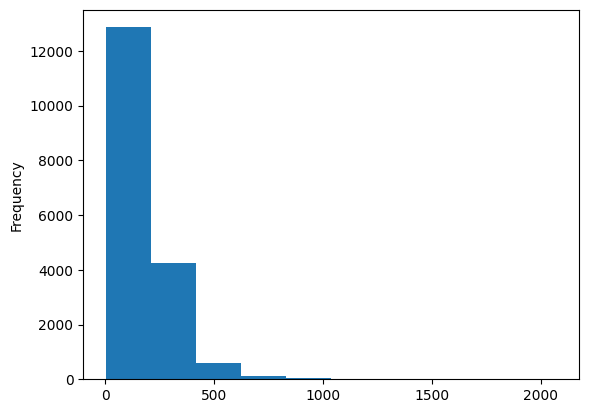

In [61]:
df['num_words'].plot.hist()

In [62]:
max_tokens = 64

In [66]:
tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(X_train.values)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [67]:
len_tokens = [len(token_list) for token_list in X_train]

(array([8.996e+03, 4.316e+03, 7.900e+02, 1.460e+02, 3.300e+01, 1.100e+01,
        1.000e+01, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0. ,  75.3, 150.6, 225.9, 301.2, 376.5, 451.8, 527.1, 602.4,
        677.7, 753. ]),
 <BarContainer object of 10 artists>)

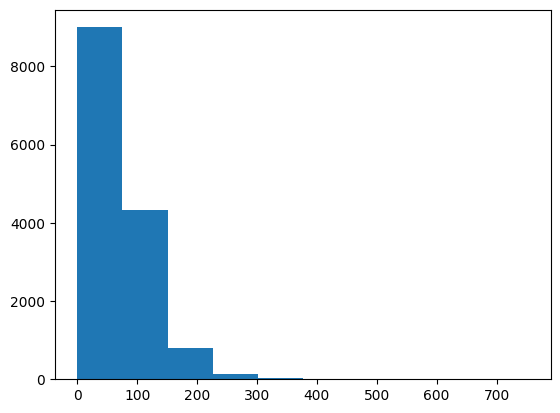

In [68]:
plt.hist(len_tokens)

In [69]:
maxlen=16

In [72]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [74]:
X_train.shape, X_test.shape

((14303, 16), (3576, 16))

In [76]:
model = Sequential()
model.add(Embedding(max_tokens, 32, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

In [77]:
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [78]:
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=64, epochs=10)

Epoch 1/10
179/179 [==============================] - 23s 41ms/step - loss: 0.2212 - precision: 0.9518 - recall: 0.9518 - val_loss: 0.1969 - val_precision: 0.9486 - val_recall: 0.9486
Epoch 2/10
179/179 [==============================] - 4s 21ms/step - loss: 0.1725 - precision: 0.9532 - recall: 0.9532 - val_loss: 0.1860 - val_precision: 0.9486 - val_recall: 0.9486
Epoch 3/10
179/179 [==============================] - 4s 20ms/step - loss: 0.1608 - precision: 0.9536 - recall: 0.9536 - val_loss: 0.1830 - val_precision: 0.9493 - val_recall: 0.9493
Epoch 4/10
179/179 [==============================] - 7s 40ms/step - loss: 0.1478 - precision: 0.9597 - recall: 0.9597 - val_loss: 0.1668 - val_precision: 0.9556 - val_recall: 0.9556
Epoch 5/10
179/179 [==============================] - 4s 21ms/step - loss: 0.1330 - precision: 0.9640 - recall: 0.9640 - val_loss: 0.1698 - val_precision: 0.9535 - val_recall: 0.9535
Epoch 6/10
179/179 [==============================] - 4s 21ms/step - loss: 0.1198 - 

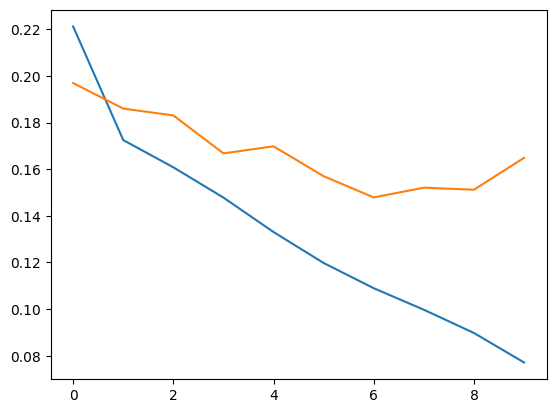

In [79]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

In [80]:
preds = model.predict(X_test)

112/112 [==============================] - 1s 5ms/step


In [81]:
print(classification_report(np.argmax(Y_test.values, axis=1), np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3394
           1       0.84      0.39      0.53       182

    accuracy                           0.97      3576
   macro avg       0.90      0.69      0.76      3576
weighted avg       0.96      0.97      0.96      3576

